# Install Dependencies

In [11]:
# #Install ALL dependencies if missing
# !pip install chembl_webresource_client
# ! pip install rdkit
# !pip install lazypredict

# Data Retreival


In [12]:
import pandas as pd
from chembl_webresource_client.new_client import new_client


**Retrieve the ID of Receptor protein-tyrosine kinase erbB-2.** This will be used as the targer protein for further research.

Receptor tyrosine-protein kinase erbB-2, also known as HER2, is a member of the epidermal growth factor receptor (EGFR) family that plays a critical role in cell growth and differentiation. Overexpression of this protein is highly correlated with breast and certain gastric cancers making it a common target for theraputic studies.






In [13]:
#Search for a target protein of HW

target = new_client.target
target_query=target.search("HER2")
targets = pd.DataFrame.from_dict(target_query)
selected_target=targets.target_chembl_id[1]


Query the activity library of cheEMBL and retrieve all compounds that target HER2 and that USE IC50 to record their stadnard_type. IC50 is measured in uM and illustrates 50% efficacy in inhibiting the target protein.


In [14]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type='IC50')

df = pd.DataFrame.from_dict(res)


In [15]:
print(df.shape)
df.dropna(subset=['standard_value', 'canonical_smiles'], inplace=True)
df.shape

(4156, 46)


(3224, 46)

# Data Pre-Processing

In [16]:
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,32264,[],CHEMBL845865,Inhibition of autophosphorylation of human Her...,F,None,None,BAO_0000190,...,Homo sapiens,Receptor protein-tyrosine kinase erbB-2,9606,None,None,IC50,uM,UO_0000065,None,0.3
1,None,None,32266,[],CHEMBL615491,Inhibition of ligand induced proliferation in ...,F,None,None,BAO_0000190,...,Homo sapiens,Receptor protein-tyrosine kinase erbB-2,9606,None,None,IC50,uM,UO_0000065,None,2.5
2,None,None,32271,[],CHEMBL683802,Inhibition of autophosphorylation of human Her...,F,None,None,BAO_0000190,...,Homo sapiens,Receptor protein-tyrosine kinase erbB-2,9606,None,None,IC50,uM,UO_0000065,None,0.4
3,None,None,32273,[],CHEMBL615491,Inhibition of ligand induced proliferation in ...,F,None,None,BAO_0000190,...,Homo sapiens,Receptor protein-tyrosine kinase erbB-2,9606,None,None,IC50,uM,UO_0000065,None,1.21
4,None,None,47937,[],CHEMBL683802,Inhibition of autophosphorylation of human Her...,F,None,None,BAO_0000190,...,Homo sapiens,Receptor protein-tyrosine kinase erbB-2,9606,None,None,IC50,uM,UO_0000065,None,0.1


Labeling compounds as active, inactive, or intermediate

IC50 >= 1000nM are active
IC50 <= 1000 nM are inactive
Everything in between is intermediate

In [17]:
bioactvity_class = []

for i in df.standard_value:
  if float(i) >= 10000:
    bioactvity_class.append("inactive")
  elif float(i) <= 1000:
    bioactvity_class.append("active")
  else:
    bioactvity_class.append("intermediate")

len(bioactvity_class)

3224

Now we extract the relevant data.

**The Canonical SMILES **(Simplified Molecular Input Line Entry System) is a standardized text representation of the molecular structure of a compound.

Example: CC(=O)OC1=CC=CC=C1C(=O)O (Aspirin)

**Molecule ChEMBL Id**

This is the unique identifier for a compound (molecule) in the ChEMBL database.

**Standard Value**

The numeric value of the measured activity for the compound, in the standardized unit specified (e.g., IC50 in nanomolar).
        Example: 200 (for an IC50 value of 200 nM)


Then we concat the previously computed bioactivity class to each compound.

In [18]:
selection = ['molecule_chembl_id', "canonical_smiles", "standard_value" ]
selected_df = df[selection]
bioactivity = pd.Series(bioactvity_class, name="bioactivity_class")

selected_df.shape, bioactivity.shape
selected_df = selected_df.reset_index(drop=True)
bioactivity = bioactivity.reset_index(drop=True)
final_df = pd.concat([selected_df, bioactivity], axis=1)

In [19]:
final_df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,300.0,active
1,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,2500.0,intermediate
2,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,400.0,active
3,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,1210.0,intermediate
4,CHEMBL67057,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,100.0,active
...,...,...,...,...
3219,CHEMBL483321,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,10.0,active
3220,CHEMBL466397,CCc1cc(Nc2nccc(-c3c(-c4ccc(OC)c(C(=O)Nc5c(F)cc...,10000.0,inactive
3221,CHEMBL466397,CCc1cc(Nc2nccc(-c3c(-c4ccc(OC)c(C(=O)Nc5c(F)cc...,10000.0,inactive
3222,CHEMBL1852688,CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(O...,10000.0,inactive


Now we save the clean dataframe as a csv file in Google Drive

In [20]:
FILE_PATH = 'bioactivity_data_her2.csv'
final_df.to_csv(FILE_PATH, index=False)

# EDA

**RDkit** allows us to compute the molecular descriptors from the compounds we previously collected.

RDKit uses the smiles notation (chemical structure) to compute the moecular descriptors.

The IC50 will be filtered for active and inactive to compare them.

In [ ]:

#Colab installations
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.10.4/site-packages/')



In [22]:
FILE_PATH = 'bioactivity_data_her2.csv'

df=pd.read_csv(FILE_PATH)
df.shape

(3224, 4)

Compute **Lipinski Descriptors**

Set of rules used to evaluate the drug-likeness of compounds which depends on
1. Absorption
2. Distribution
3. Metbolism
4. Excretion

ADME - tells us relative drug likeness of a compound. There are specific characteristics:

Mol Weight <= 500 Dalton

LogP <= 5

H bond donors <= 5

H bond acceptors <= 10

In [23]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Taken from https://github.com/dataprofessor/code/blob/master/python/CDD_ML_Part_2_Exploratory_Data_Analysis.ipynb

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors



df_lipinskli = lipinski(df.canonical_smiles)


Now we will concat the df we previously retrieved along with the lipisnki df.

In [24]:
df_combined =pd.concat([df, df_lipinskli], axis=1)
df_combined.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,300.0,active,383.814,4.45034,3.0,4.0
1,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,2500.0,intermediate,383.814,4.45034,3.0,4.0
2,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,400.0,active,482.903,3.61432,3.0,6.0
3,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,1210.0,intermediate,482.903,3.61432,3.0,6.0
4,CHEMBL67057,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,100.0,active,559.630,4.82482,3.0,7.0


Convert IC50 to PIC50 (negative logarithmic scale) to make the distribution more even. First we normalize the data, maxing it out at 100,000,000.

Then we convert the IC50 into pIC50. We can see that with IC50 the distribution is highly skewed to the right and after the transformation it is has a rough normal disstribution.

In [25]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis=1)

    return x

def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100_000_000:
          i = 100_000_000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x



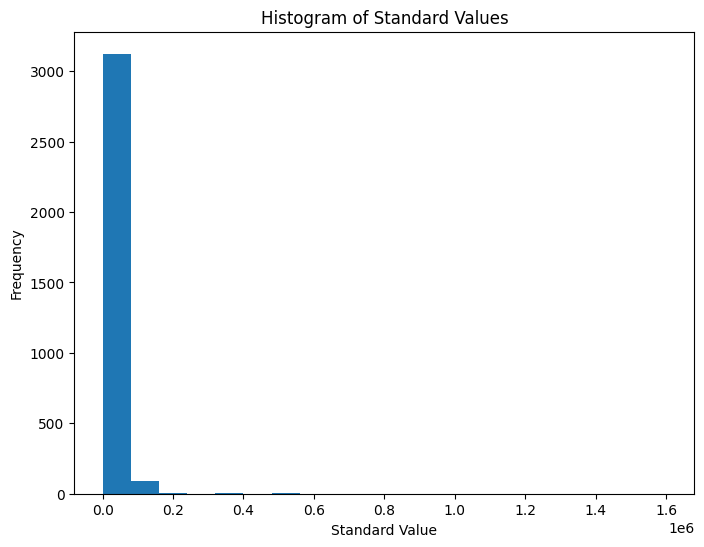

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.hist(df['standard_value'], bins=20)
plt.title('Histogram of Standard Values')
plt.xlabel('Standard Value')
plt.ylabel('Frequency')
plt.show()

In [27]:
print(df_combined['standard_value'].describe())

count    3.224000e+03
mean     8.326747e+03
std      4.333040e+04
min      6.000000e-02
25%      4.800000e+01
50%      2.000000e+02
75%      2.700000e+03
max      1.600000e+06
Name: standard_value, dtype: float64


In [28]:
df_norm = norm_value(df_combined)
df_final = pIC50(df_norm)
df_final
(df_norm['standard_value_norm'].describe())

count    3.224000e+03
mean     8.326747e+03
std      4.333040e+04
min      6.000000e-02
25%      4.800000e+01
50%      2.000000e+02
75%      2.700000e+03
max      1.600000e+06
Name: standard_value_norm, dtype: float64

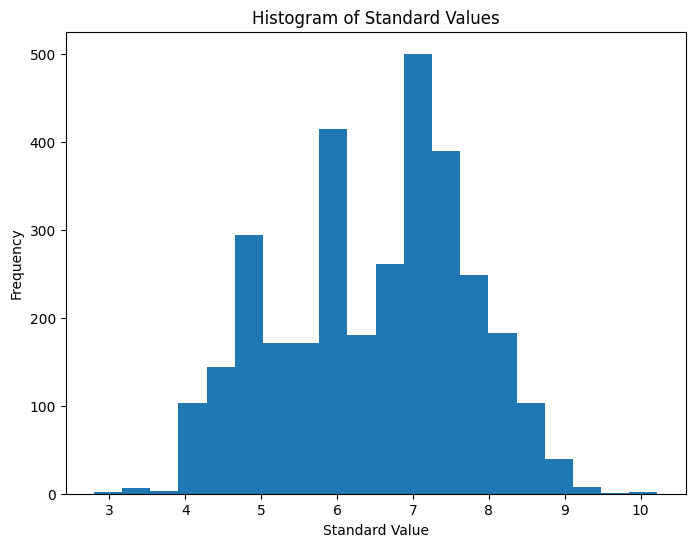

In [29]:
# Plotting a simple histogram
plt.figure(figsize=(8, 6))
plt.hist(df_final['pIC50'], bins=20)
plt.title('Histogram of Standard Values')
plt.xlabel('Standard Value')
plt.ylabel('Frequency')
plt.show()

Now we remove the intermediate class so we can compare active and inactive

In [30]:
df_final = df_final[df_final['bioactivity_class'] != 'intermediate']



# EDA (Chemical Space Analysis)

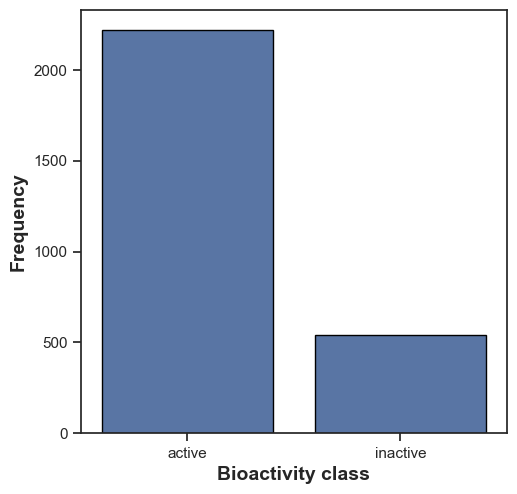

In [31]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_final, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')


**Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning somewhat similar chemical spaces as evident by the scatter plot of MW vs LogP.

However a few things are noticable:
The plot shows that active compounds dominate at higher molecular weight and LogP values, indicating a trend where higher hydrophobicity and molecular size correlate with bioactivity.

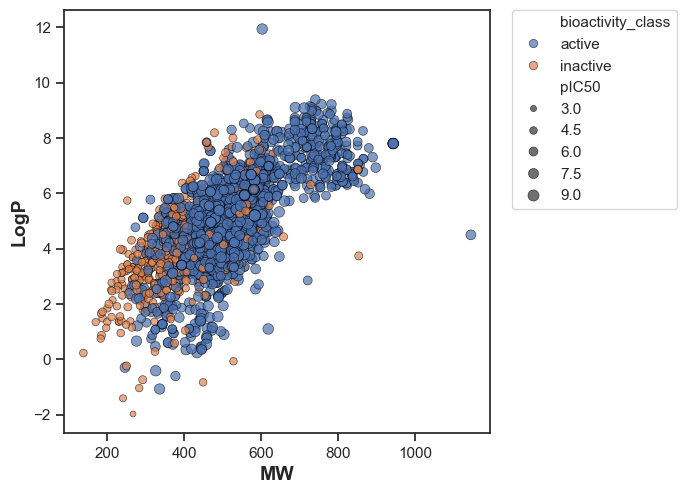

In [32]:


plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_final, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')



In [33]:
df_active = df_final[df_final['bioactivity_class'] == 'active']
df_inactive = df_final[df_final['bioactivity_class'] == 'inactive']


The analysis reveals that active compounds tend to have higher mean, median, and standard deviation values for Molecular Weight compared to inactive compounds. This suggests that Molecular Weight could be a key factor influencing the bioactivity of a drug. Specifically:

In [34]:
from scipy import stats

active_mean = df_active['MW'].mean()
active_median = df_active['MW'].median()
active_std = df_active['MW'].std()

inactive_mean = df_inactive['MW'].mean()
inactive_median = df_inactive['MW'].median()
inactive_std = df_inactive['MW'].std()

print("Statistics for Active Compounds (MW):")
print(f"Mean: {active_mean:.2f}")
print(f"Median: {active_median:.2f}")
print(f"std: {active_std:.2f}")


print("\nStatistics for Inactive Compounds (MW):")
print(f"Mean: {inactive_mean:.2f}")
print(f"Median: {inactive_median:.2f}")
print(f"std: {inactive_std:.2f}")



Statistics for Active Compounds (MW):
Mean: 527.30
Median: 507.98
std: 116.12

Statistics for Inactive Compounds (MW):
Mean: 397.42
Median: 380.40
std: 112.63


In [35]:
from scipy import stats

active_mean = df_active['LogP'].mean()
active_median = df_active['LogP'].median()
active_std = df_active['LogP'].std()

inactive_mean = df_inactive['LogP'].mean()
inactive_median = df_inactive['LogP'].median()
inactive_std = df_inactive['LogP'].std()

print("Statistics for Active Compounds (LogP):")
print(f"Mean: {active_mean:.2f}")
print(f"Median: {active_median:.2f}")
print(f"std: {active_std:.2f}")


print("\nStatistics for Inactive Compounds (LogP):")
print(f"Mean: {inactive_mean:.2f}")
print(f"Median: {inactive_median:.2f}")
print(f"std: {inactive_std:.2f}")


Statistics for Active Compounds (LogP):
Mean: 5.08
Median: 5.00
std: 1.61

Statistics for Inactive Compounds (LogP):
Mean: 4.02
Median: 3.89
std: 1.60


In [36]:


def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_final[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results


mannwhitney('pIC50')



,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1198800.0,1.252606e-285,0.05,Different distribution (reject H0)


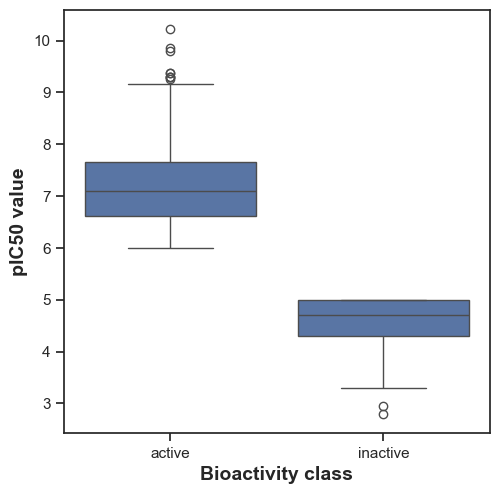

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

Test statistical differenece.

EX: compare active and inactive class and compare difference for pIC50. p-value of 1,66 e ^ -10 -->  significantly different in distribution

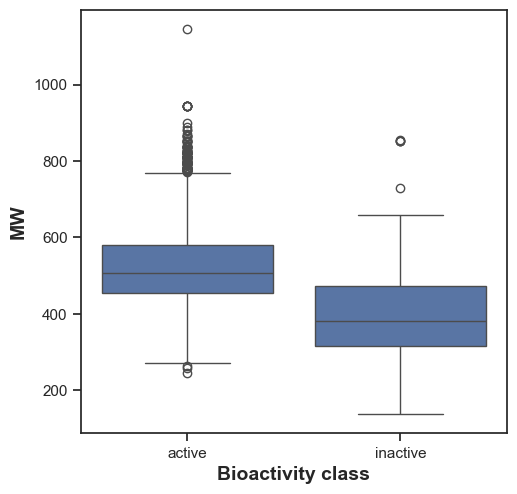

In [38]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [39]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,952721.0,1.963998e-100,0.05,Different distribution (reject H0)


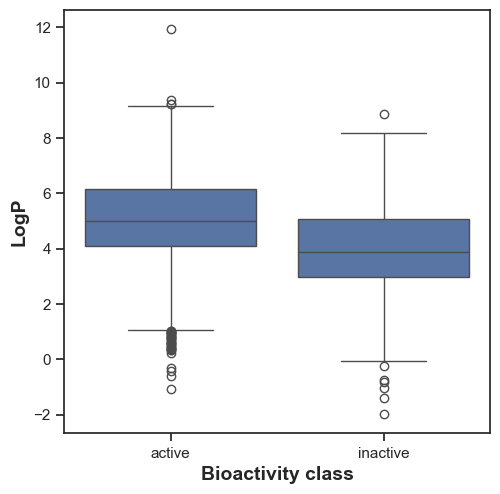

In [40]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [41]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,824667.5,6.557251e-42,0.05,Different distribution (reject H0)


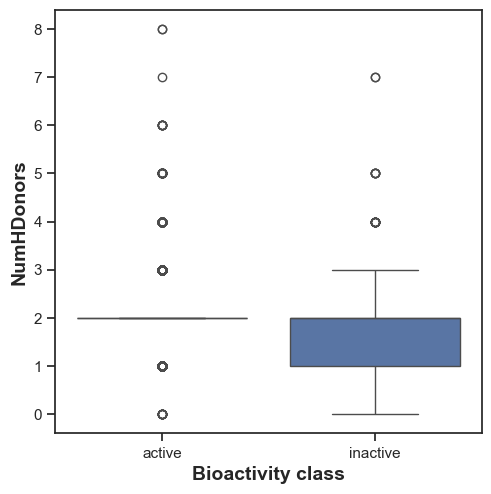

In [42]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')


In [43]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,757397.0,2.209351e-25,0.05,Different distribution (reject H0)


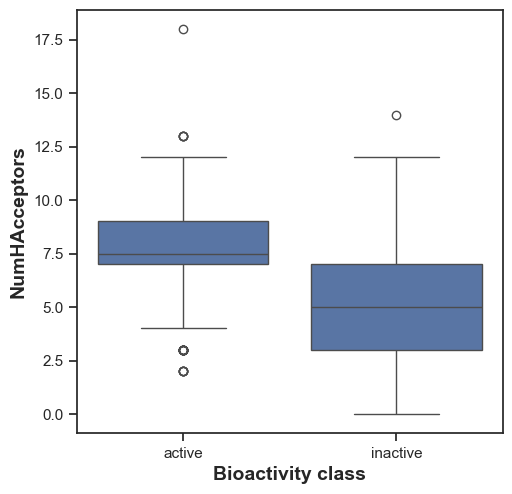

In [44]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_final)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [45]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,954182.5,1.084936e-103,0.05,Different distribution (reject H0)


Since the data is extrmely imbalanced, we can use the welch test to test for siginficance.

In [46]:
welch_active = df_final[df_final['bioactivity_class'] == 'active']
welch_inactive = df_final[df_final['bioactivity_class'] == 'inactive']



In [47]:
from scipy import stats
t_stat_pIC50, p_value_pIC50 = stats.ttest_ind(welch_active['pIC50'], welch_inactive['pIC50'], equal_var=False)
t_stat_logP, p_value_logP = stats.ttest_ind(welch_active['LogP'], welch_inactive['LogP'], equal_var=False)
t_stat_NumHAcceptors, p_value_NumHAcceptors = stats.ttest_ind(welch_active['NumHAcceptors'], welch_inactive['NumHAcceptors'], equal_var=False)
t_stat_NumHDonors, p_value_NumHDonors = stats.ttest_ind(welch_active['NumHDonors'], welch_inactive['NumHDonors'], equal_var=False)


print(f"T-statistic for pIC50: {t_stat_pIC50}, P-value for pIC50: {p_value_pIC50}")
print(f"T-statistic for LogP: {t_stat_logP}, P-value for LogP: {p_value_logP}")
print(f"T-statistic for NumHAcceptors: {t_stat_NumHAcceptors}, P-value for NumHAcceptors: {p_value_NumHAcceptors}")
print(f"T-statistic for NumHDonors: {t_stat_NumHDonors}, P-value for NumHDonors: {p_value_NumHDonors}")


T-statistic for pIC50: 107.36479251712802, P-value for pIC50: 0.0
T-statistic for LogP: 13.767792476370287, P-value for LogP: 5.5261807065749755e-39
T-statistic for NumHAcceptors: 23.391686024664477, P-value for NumHAcceptors: 2.6180630708178685e-90
T-statistic for NumHDonors: 9.23090372179235, P-value for NumHDonors: 2.8700614595410623e-19


In [48]:
! zip -r results.zip . -i *.csv *.pdf

updating: mannwhitneyu_NumHAcceptors.csv (deflated 11%)
updating: mannwhitneyu_NumHDonors.csv (deflated 11%)
updating: mannwhitneyu_MW.csv (deflated 9%)
updating: plot_bioactivity_class.pdf (deflated 39%)
updating: plot_LogP.pdf (deflated 38%)
updating: plot_MW.pdf (deflated 38%)
updating: plot_NumHDonors.pdf (deflated 37%)
updating: plot_NumHAcceptors.pdf (deflated 38%)
updating: plot_ic50.pdf (deflated 36%)
updating: bioactivity_data_her2.csv (deflated 85%)
updating: mannwhitneyu_pIC50.csv (deflated 11%)
updating: plot_MW_vs_LogP.pdf (deflated 3%)
updating: mannwhitneyu_LogP.csv (deflated 9%)
  adding: descriptors_output.csv (deflated 96%)
  adding: bioactivity_data_pic50.csv (deflated 81%)
  adding: HER2_bioactivity_PIC50_pubchem_fp.csv (deflated 96%)


Summary: Active and inacitve display significant difference in LogP
H-accetor, H-donor, and MW.

These results could be innacurate due to the imbalanced distribution of active and inactive bioactivity recordings so we used a welch test to confirm our results.

The Welch’s t-test results show highly significant differences between the active and inactive groups. These results support the evidence that there are substantial differences in the molecular descriptors between the two groups (active/inactive).

In [49]:
FILE_PATH = 'bioactivity_data_pic50.csv'

df_final.to_csv(FILE_PATH, index=False)

Delete all files from directory (stored in results )

In [50]:
! rm *.pdf
! rm mannwhitney*.csv

# Dataset Preparation


In [51]:
import pandas as pd

FILE_PATH = 'bioactivity_data_pic50.csv'

df=pd.read_csv(FILE_PATH)
df

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL68920,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...,active,383.814,4.45034,3.0,4.0,6.522879
1,CHEMBL69960,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,active,482.903,3.61432,3.0,6.0,6.397940
2,CHEMBL67057,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...,active,559.630,4.82482,3.0,7.0,7.000000
3,CHEMBL69629,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncn...,active,525.972,3.20392,4.0,7.0,7.000000
4,CHEMBL66570,CCN1CCN(C(=O)c2cc(C)c(/C=C3\C(=O)Nc4ncnc(Nc5cc...,active,509.973,3.91962,3.0,6.0,7.000000
...,...,...,...,...,...,...,...,...
2755,CHEMBL483321,COCC(=O)NC/C=C/c1ccc2ncnc(Nc3ccc(Oc4ccc(C)nc4)...,active,469.545,4.95334,2.0,7.0,8.000000
2756,CHEMBL466397,CCc1cc(Nc2nccc(-c3c(-c4ccc(OC)c(C(=O)Nc5c(F)cc...,inactive,851.981,6.85800,2.0,12.0,5.000000
2757,CHEMBL466397,CCc1cc(Nc2nccc(-c3c(-c4ccc(OC)c(C(=O)Nc5c(F)cc...,inactive,851.981,6.85800,2.0,12.0,5.000000
2758,CHEMBL1852688,CCN1CCN(c2ccc(Nc3cc(N(C)C(=O)Nc4c(Cl)c(OC)cc(O...,inactive,560.486,5.35440,2.0,8.0,5.000000


We will calculate molecular descriptors that will serve as a quantiative method to describe the compounds in the dataset.
Then we will prepare the data form model building

In [52]:
#Download the PaDEL-Descriptor to calculate molecular descriptors

! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

/bin/bash: wget: command not found
/bin/bash: wget: command not found


In [53]:
! unzip padel.zip

unzip:  cannot find or open padel.zip, padel.zip.zip or padel.zip.ZIP.


 saves the cancoical smiles and ids as a tab-delimited .smi file, with each row representing a molecule's SMILES string.

In [54]:
selection = ['canonical_smiles', 'molecule_chembl_id']
df_selection = df[selection]
df_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [55]:
! cat molecule.smi | head -5

Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)c32)[nH]1	CHEMBL68920
Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F)c(Cl)c3)c21	CHEMBL69960
Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc4c(ccn4Cc4ccccc4)c3)c21	CHEMBL67057
Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(Nc3ccc(F)c(Cl)c3)c21	CHEMBL69629
CCN1CCN(C(=O)c2cc(C)c(/C=C3\C(=O)Nc4ncnc(Nc5ccc(F)c(Cl)c5)c43)[nH]2)CC1	CHEMBL66570
cat: stdout: Broken pipe


In [56]:
! cat molecule.smi | wc -l

    2760


Lipinski descriptors -  overview of the molecules and their drug-like properties. Passing the rule of 5 will make good oral drugs. Represnets global features of the molecule

PubChem fingerprints - local features of the molecules (each molecule described by the unique building block of the molecule). We investigate the atoms and their bonds. The connectivity gives rise to the structure and properties of the molecule. We want to rearrange the molecule so that it is safe yet potent.


this file contains java code to remove salt (sodium and chloride in the chemical structure) and small organic acids. We clean the chemical structure to avoid impurity. Once it is done it will generate a descriptors_output.csv file


In [57]:
# ! bash padel.sh

In [58]:
df_X = pd.read_csv('descriptors_output.csv')


Prepare X and Y data matrices. X will be the molecular rescriptors. Drop the name column Y will be the pIC50

In [59]:
df_X = df_X.drop(columns=['Name'])
df_Y = df['pIC50']

In [60]:
dataset = pd.concat([df_X, df_Y], axis=1)

In [61]:
dataset.to_csv('HER2_bioactivity_PIC50_pubchem_fp.csv', index=False)

# Modeling

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

Each molecule has a unique 'fingerptint' that will be used my the ML model to predict which fingerprint is essential for designing a potent drug (by predicting the pIC50)

In [2]:
FILE_PATH = 'HER2_bioactivity_PIC50_pubchem_fp.csv'
df=pd.read_csv(FILE_PATH)
df


,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.522879
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.397940
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
4,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.000000
2756,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
2757,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000
2758,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.000000


In [3]:
X = df.drop('pIC50', axis =1)
y = df.pIC50

In [4]:
X.shape, y.shape

((2760, 881), (2760,))

Remove low variance features, specifically, features with a variancle below .16
since they carry little information and is less useful for distinguishing between samples.

In [5]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1-.8)))
X = selection.fit_transform(X)
X.shape

(2760, 137)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size=.2)

In [7]:
X_train.shape, X_test.shape

((2208, 137), (552, 137))

Build a regression model using Random Forest .44 is the r2 score.

R2 quantifies the percentage of variance in the target variable (pIC50) that is explained by the model based on the features(PubChem fingerprints)

In [8]:
import numpy as np
np.random.seed(100)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.47516215853186705

In [9]:
Y_pred = model.predict(X_test)

Plot Experimental vs Predicted pIC50 values

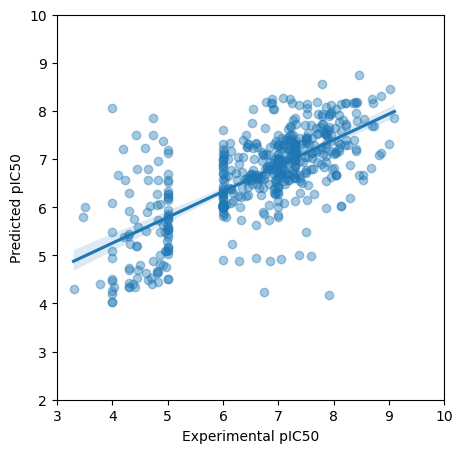

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.regplot(x=Y_test, y=Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50')
ax.set_ylabel('Predicted pIC50')
ax.set_xlim(3, 10)
ax.set_ylim(2, 10)
ax.figure.set_size_inches(5, 5)
plt.show()


Random Forest performed moderately so we can test other models.

In [11]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

Build 42 models using lazy predict. We train and test the data like in sklearn. Builds different regression models. No hyperparameter tuning yet.

In [12]:
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
train, test = clf.fit(X_train, X_test, Y_train, Y_test)


100%|██████████| 42/42 [00:21<00:00,  1.92it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 2208, number of used features: 137
[LightGBM] [Info] Start training from score 6.659645


We can see that  RandomForestRegressor still performed the best but the results are poor

In [13]:
test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.28,0.46,0.87,1.34
RandomForestRegressor,0.28,0.46,0.87,2.13
NuSVR,0.28,0.46,0.88,0.52
SVR,0.27,0.45,0.88,0.61
LGBMRegressor,0.26,0.44,0.89,0.15
GradientBoostingRegressor,0.25,0.44,0.89,1.12
MLPRegressor,0.24,0.43,0.90,2.83
BaggingRegressor,0.23,0.42,0.91,0.23
XGBRegressor,0.22,0.42,0.91,0.39


EX: R² = 0.5 means that 50% of the variance in pIC50 can be explained by the model.

[(0.0, 1.0)]

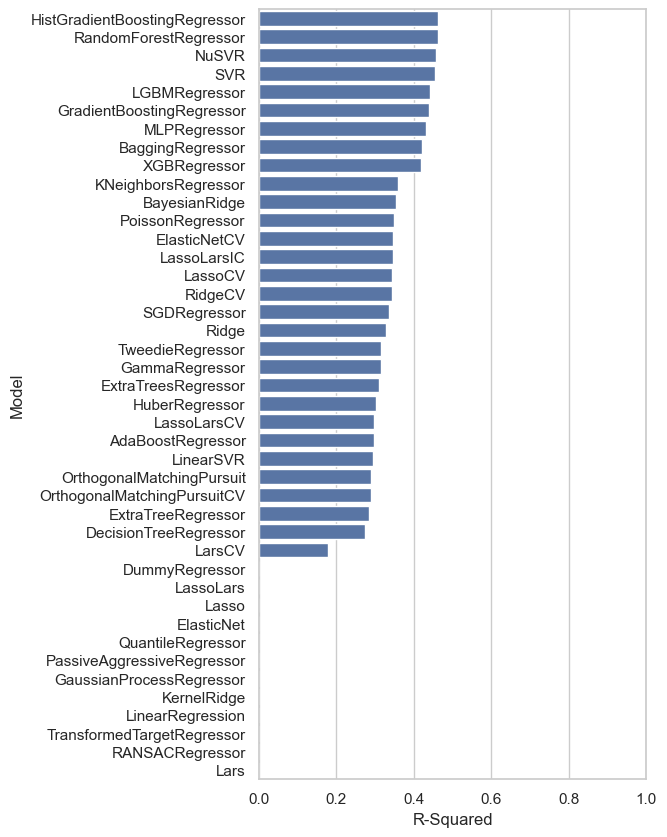

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y='Model', x="R-Squared", data=test)
ax.set(xlim=(0, 1))

RMSE values tells us the average magnitude of the errors between predicted and actual values.
EX: An RMSE of 0.2 nM means that, on average, means that predictions are off by 0.2 micro-molar.

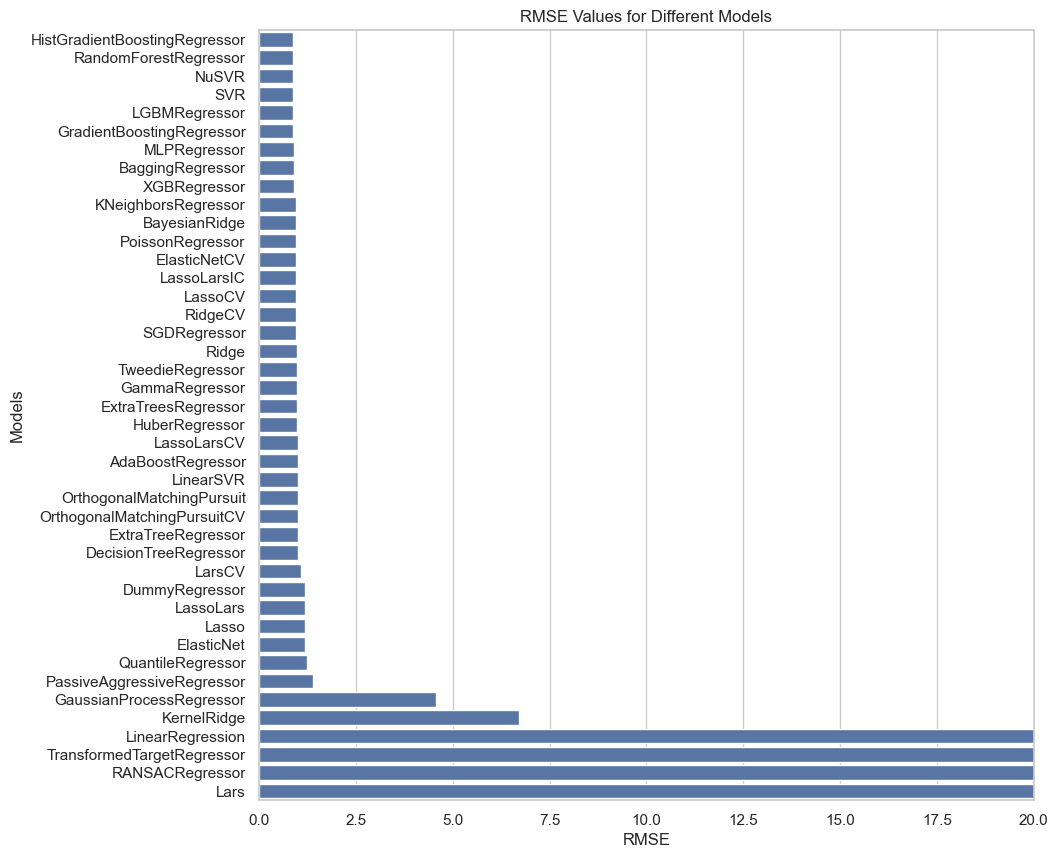

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.set_theme(style="whitegrid")

ax = sns.barplot(y='Model', x='RMSE', data=test)

ax.set(xlim=(0, 20))

ax.set_xlabel('RMSE')
ax.set_ylabel('Models')
ax.set_title('RMSE Values for Different Models')

plt.show()


EX: A 0.27 adjusted R-squared is relatively low/ It’s suggesting that the model might be overfitting or other features need to be used to explain the model.

[(0.0, 1.0)]

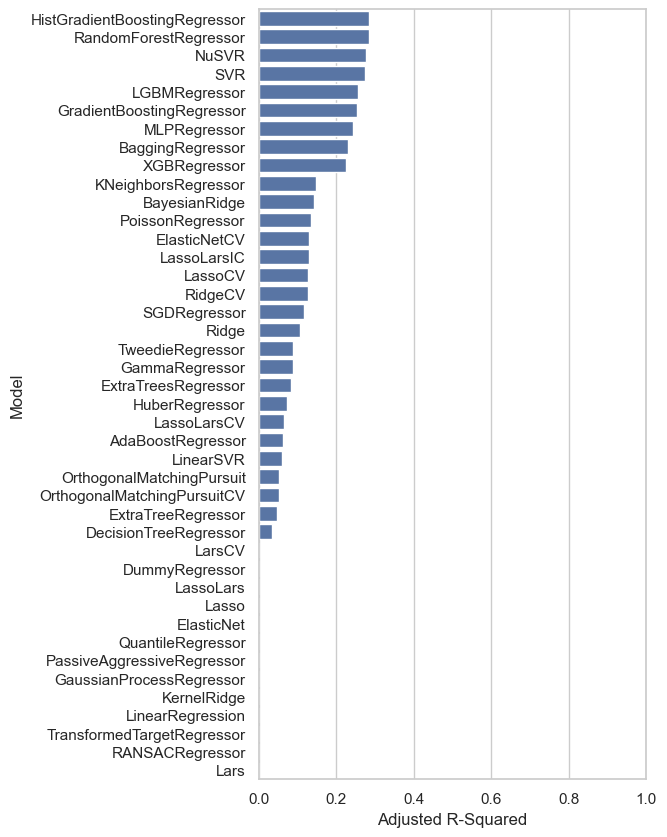

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y='Model', x="Adjusted R-Squared", data=test)
ax.set(xlim=(0, 1))

# Hyperparameter Tuning


Since the random forest model performed best we will use some hypermaramter tuning to try and improve its performance.

 Use GridCVSearch to search for the best parameters.
1. n_estimators: # of trees in the model
2. max_depth: maximum depth of each tree in the forest.
3. min_samples_split: minimum number of samples required to split a node
4. min_samples_leaf: minimum number of samples required to be in a leaf node


cv: Cross-validation splits the data into folds(5), and for each combination of hyperparameters, the model is trained on different subsets
scoring: use r2 as the scoring mechanism

The R2 score has been improved from .44 to .50.

In [ ]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, Y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10], 'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2], 'n_estimators': [100]},
             scoring='r2')

Since r2 score is relatively moderate even after hyperparameter tuning, we will go back to do some feature engineering

In [ ]:
print(grid_search.best_params_)
print (grid_search.best_estimator_)
print("Best R2 score: ", grid_search.best_score_)

{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestRegressor(max_depth=10)
Best R2 score:  0.5203404335453404
(2760, 137)
(2760,)


(None, None)

Results :
1. Decent R² score of 0.52
2.  moderate error level (around 12.96% relative to the mean of the target values).
3. RMSE of .862 - predictions were off by .862 molar on average with respect to pIC50.

In [ ]:
from sklearn.metrics import root_mean_squared_error

rmse = root_mean_squared_error(Y_test, Y_pred)
print("Root Mean Squared Error:", rmse)

percentage_error = (rmse / np.mean(y)) * 100
print(f"Percentage Error: {percentage_error:.2f}%")

print("Best R2 score: ", grid_search.best_score_)


Root Mean Squared Error: 0.8621362549955681
Percentage Error: 12.96%
Best R2 score:  0.5203404335453404
Max y:  10.221848749616356
Min y:  2.795880017344075


Store the model using pickle

In [57]:
import pickle

with open('her2_rf_model.pkl', 'wb') as file:
    pickle.dump(grid_search, file)